# Analysis for QP2
## 12/13/25
## Vincent Mariani

* Added question a/b logistic model on 12/14 @ 11:30
---



### Data Prep work: 
- Load packages
- Read data from files
- Filter to just needed sentences
- Filter to just needed NPs

(At any point use ```write_rds()``` or ```write_parquet()``` to save a dataframe, and ```read_rds()``` or ```open_dataset()``` respectively to open them.)

#### Loading Packages: 

In [7]:
# Loading Packages
library(tidyverse)
library(easystats)

library(data.table) # For speed
library(dtplyr) # Allows for splyr syntax with data.table
library(arrow) # Allows saving as a .parquet file (much smaller than RDS)

# Attaching packages: easystats 0.7.5
✔ bayestestR  0.17.0   ✔ correlation 0.8.8 
✔ datawizard  1.3.0    ✔ effectsize  1.0.1 
✔ insight     1.4.4    ✔ modelbased  0.13.1
✔ performance 0.15.3   ✔ parameters  0.28.3
✔ report      0.6.2    ✔ see         0.12.0




#### Reading in Data:

Option 1: Loading directly from CSV files:

In [ ]:

# files <- list.files(path = "<FILEPATH>",
#                     pattern = "\\.csv$",
#                     full.names = TRUE)

# df_full <- read_csv(files, id = "file_name")



## Turns into lazy data.table for memory and speed, then clears full df until after cleanup: 
# df_full_laz <- lazy_dt(df_full) 
#     rm(df_full)
#     gc()

Option 2: Load from RDS

In [ ]:
# df_full <- read_rds("<FILEPATH>")

# # Turns into lazy data.table for memory and speed, then clears full df until after cleanup: 
# df_full_laz <- lazy_dt(df_full) 
#     rm(df_full)
#     gc()

Option 3: Load from Parquet

In [2]:
df_full_laz <- open_dataset("Parquets 12-12 Run/12-12 Full Data.parquet") # No need to run lazy_dt(); parquet automatically reads as a dt instead of a df.

#### Filter the Data

1. Filter to just needed sentences; also add tag to determine index of the first token of each NP.

In [3]:
df_sent <- df_full_laz %>% 
#
    # Filters to given Criteria
        filter(
        Modality == "written", 
        Sent_Verb_Count == 1,
        Sent_Auxiliary_Count == 0,
        Sent_Subject_Count == 1,
        Sent_Tot_Obj_Count %in% 1,
        Sent_Dir_Object_Count == 1 ,
        Sent_Ind_Object_Count == 0,
        Sent_Sub_Conj_Count == 0,
        Sent_Coord_Conj_Count == 0, 
        Clausal_Complement_Count == 0,
        Sent_Relative_Clause_Count == 0, 
        Sent_Adv_Clause_Count == 0, 
        Sent_Prep_Phrase_Count == 0,
        Sent_Comma_Count == 0,
        !str_detect(Sentence_Text, "\\?"),
        Sent_Transitive == TRUE,
    )  %>%
#
# Removes unneeded columns and collects dt into regular df
    select(Sentence_ID, Sentence_Text, Word_Token_Index, Word_Token, Word_Surprisal, Phrase_Token, Is_NP, Is_Head_Noun, NP_Head_Text, file_name, Filename, NP_Definiteness, NP_Argument, Phrase_Surprisal) %>%
    collect() %>%
#
# Changes names and sets baselines for definiteness, argument position, and surprisal
    mutate(
        definiteness = factor(NP_Definiteness,
        levels = c("indefinite", "definite"),
        labels = c("indef", "def"))
    ) %>% 
    mutate(
        argPos = factor(
            NP_Argument,
            levels = c("dir_object", "subject"),
            labels = c("obj", "sbj")
        )
    ) %>% 
    mutate(surprisal = Phrase_Surprisal) %>%
#
# Tags index of the first token in each NP
    # Finds the token
    arrange(Sentence_ID, Word_Token_Index) %>% 
    group_by(Sentence_ID) %>% 
    mutate(
        prev_is_NP = lag(Is_NP, default = FALSE),
        prev_NP_Head_Text = lag(NP_Head_Text),

        first_token_of_NP = Is_NP & (!prev_is_NP | NP_Head_Text != prev_NP_Head_Text)
    ) %>% 
    ungroup() %>% 
#
    # Grabs index and copies to all rows in NP
    select(-prev_is_NP, -prev_NP_Head_Text) %>% 
    group_by(Sentence_ID, np_id = consecutive_id(Phrase_Token)) %>% 
    mutate(
        np_start_idx = ifelse(
            is.na (Phrase_Token) | Is_NP == FALSE, 
            NA,
            min(Word_Token_Index)
        )
    ) %>% 
    ungroup() %>% 
    select(-np_id) %>% 
#
# Creates per-sentence index that is sequential *within each file* (i.e., each file has 0001, 0002, 0003, ...)
    mutate(
        within_file_id = str_extract(Sentence_ID, "(?<=_)\\d+") %>% 
        as.integer
    ) %>%
#
# Removes sentences in which the subject is not the first word in the sentence, e.g., utterance inversion and non-cannonical sentences
    group_by(Sentence_ID) %>% 
        filter(all(
            (argPos == "sbj" & np_start_idx == 0) |
            (argPos != "sbj") |
            is.na(argPos)
        )) %>%
        ungroup() %>% 
#
# Removes sentences containing NPs that do not have valid argument positions
    group_by(Sentence_ID) %>% 
        filter(all(
            !(Is_NP == TRUE & is.na(argPos))
        )) %>% 
        ungroup() %>% 
#
# Removes duplicate sentences
    arrange(Sentence_ID) %>% 
    group_by(Sentence_Text) %>%
    mutate(first_Sentence_ID = first(Sentence_ID)) %>%
    filter(Sentence_ID == first_Sentence_ID) %>%
    ungroup() %>%
    select(-first_Sentence_ID)


summary(df_sent)



 Sentence_ID        Sentence_Text      Word_Token_Index  Word_Token       
 Length:192584      Length:192584      Min.   : 0.000   Length:192584     
 Class :character   Class :character   1st Qu.: 1.000   Class :character  
 Mode  :character   Mode  :character   Median : 3.000   Mode  :character  
                                       Mean   : 2.741                     
                                       3rd Qu.: 4.000                     
                                       Max.   :18.000                     
                                                                          
 Word_Surprisal    Phrase_Token         Is_NP         Is_Head_Noun   
 Min.   : 0.0002   Length:192584      Mode :logical   Mode :logical  
 1st Qu.: 1.6201   Class :character   FALSE:80449     FALSE:49355    
 Median : 3.1270   Mode  :character   TRUE :112135    TRUE :62780    
 Mean   : 3.8589                                      NA's :80449    
 3rd Qu.: 5.5791                                  

2. Filter to just head nouns for analysis:

In [5]:
df_nps <- df_sent %>% # Done as a normal dataframe; not large enough to bother converting back to a dt.
    filter(
        Is_NP == TRUE, # Filters to just nouns
        Is_Head_Noun == TRUE, # only head nouns
        definiteness %in% c("def", "indef"), # only valid definiteness values
        argPos %in% c("obj", "sbj"), # only nouns with valid argument positions
        !is.na(surprisal), # only nouns with valid surprisal values
    ) %>% 
    group_by(Sentence_ID) %>% #Double checks that every sentence has exactly one sentence and one object
        filter(n() == 2 & n_distinct(argPos) == 2) %>% 
        ungroup() %>% 
    select(Phrase_Token, surprisal, definiteness, argPos, np_start_idx, Sentence_ID, Sentence_Text)

summary(df_nps)

 Phrase_Token         surprisal         definiteness  argPos     
 Length:56802       Min.   :4.275e-04   indef:12904   obj:28401  
 Class :character   1st Qu.:1.957e+00   def  :43898   sbj:28401  
 Mode  :character   Median :3.341e+00                            
                    Mean   :3.910e+00                            
                    3rd Qu.:5.316e+00                            
                    Max.   :2.034e+01                            
  np_start_idx   Sentence_ID        Sentence_Text     
 Min.   : 0.00   Length:56802       Length:56802      
 1st Qu.: 0.00   Class :character   Class :character  
 Median : 1.00   Mode  :character   Mode  :character  
 Mean   : 1.31                                        
 3rd Qu.: 2.00                                        
 Max.   :16.00                                        


---


### Statistics and Plots

#### Loading Packages, etc.: 

In [3]:
library(ggplot2)
library(ggthemes)

# Global font metrics for ggPlot: 
    plotFont <- function(fontBase) { # Easy way to adjust font size for plots
        theme( # Add as a final ggplot object (no parentheses)
        plot.title = element_text(size = 14*fontBase),      # Title font size
        axis.title.x = element_text(size = 12*fontBase),    # X-axis title font size
        axis.title.y = element_text(size = 12*fontBase),    # Y-axis title font size
        axis.text.x = element_text(size = 10*fontBase),     # X-axis tick labels font size
        axis.text.y = element_text(size = 10*fontBase),     # Y-axis tick labels font size
        legend.text = element_text(size = 10*fontBase),     # Legend text size
        legend.title = element_text(size = 10*fontBase),    # Legend title size
        strip.text = element_text(size = 10*fontBase)
        )
    }

# For httpgd plot view in VS Code
options(repr.plot.width = 12, repr.plot.height = 8)

#### Statistics:

##### Definiteness and argument position:


Call:
lm(formula = surprisal ~ definiteness * argPos, data = df_nps)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.9706 -1.8992 -0.5233  1.3200 15.3363 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)                4.00425    0.02498  160.33   <2e-16 ***
definitenessdef           -1.15352    0.03076  -37.50   <2e-16 ***
argPossbj                  2.21407    0.04997   44.30   <2e-16 ***
definitenessdef:argPossbj -0.69799    0.05532  -12.62   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.457 on 56798 degrees of freedom
Multiple R-squared:  0.1126,	Adjusted R-squared:  0.1125 
F-statistic:  2402 on 3 and 56798 DF,  p-value: < 2.2e-16


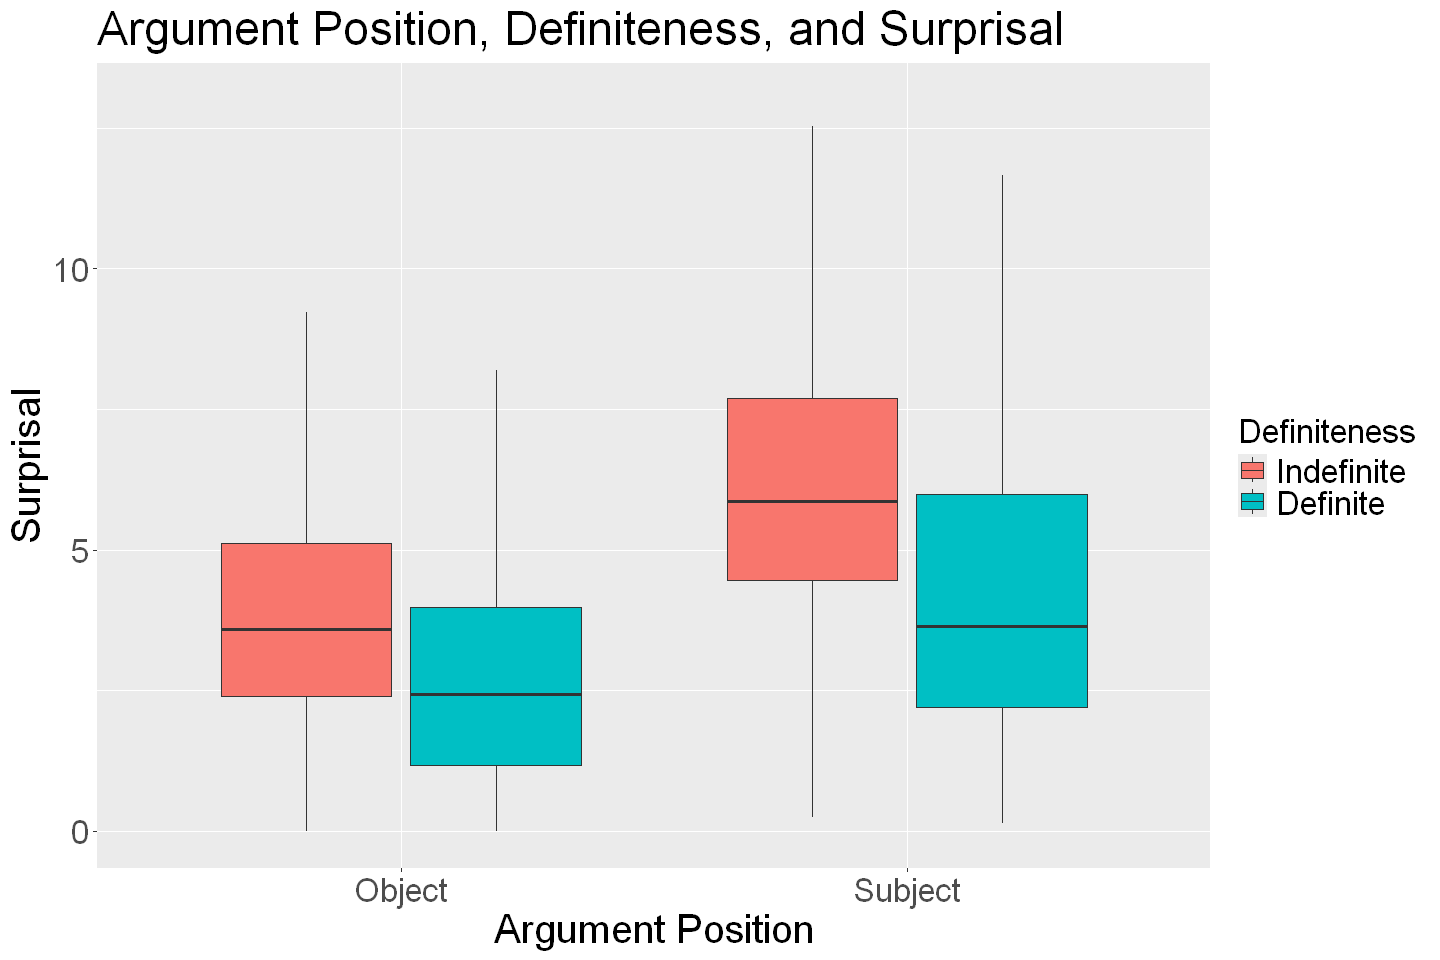

In [9]:
summary(lm(data=df_nps, surprisal ~ definiteness * argPos))

ggplot(data = df_nps, aes(y = surprisal, x = argPos, fill = definiteness)) + 
    geom_boxplot(outlier.shape = NA) + 
        coord_cartesian(ylim = c(0, 13)) + 
    labs(
        title = "Argument Position, Definiteness, and Surprisal",
        x = "Argument Position",
        y = "Surprisal",
        fill = "Definiteness"
    ) + 
    scale_x_discrete(labels = c("sbj" = "Subject", "obj" = "Object")) + 
    scale_fill_discrete(labels = c("indef" = "Indefinite", "def" = "Definite")) + 
    plotFont(2) 


- Positive effect of subjecthood
- Negative effect of definiteness
- Negative interaction:
    - Probably because most subjects in the data are definite. 

##### Is there an issue of position in the sentence? 


Call:
lm(formula = Word_Surprisal ~ Word_Token_Index, data = df_sent)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.6724 -2.1481 -0.6203  1.5974 18.5189 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       4.788069   0.010456   457.9   <2e-16 ***
Word_Token_Index -0.345010   0.003053  -113.0   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.798 on 187814 degrees of freedom
  (4768 observations deleted due to missingness)
Multiple R-squared:  0.06365,	Adjusted R-squared:  0.06365 
F-statistic: 1.277e+04 on 1 and 187814 DF,  p-value: < 2.2e-16


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'
Warning message:
"Removed 4768 rows containing non-finite outside the scale range
(`stat_smooth()`)."


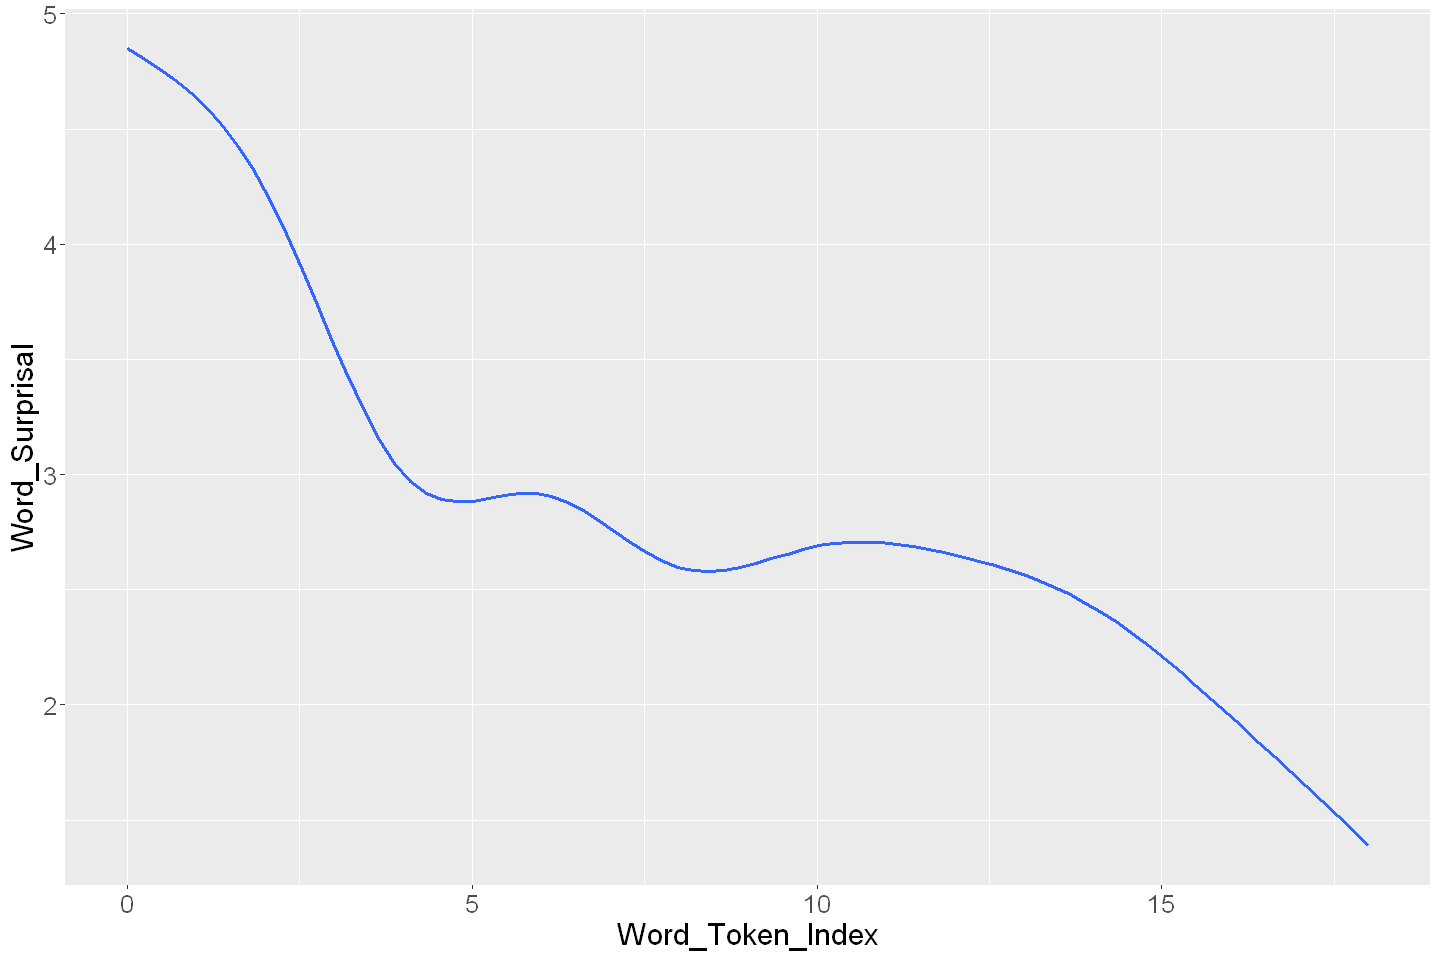

In [34]:
summary(lm(data=df_sent, Word_Surprisal ~ Word_Token_Index))

ggplot(df_sent, aes(x = Word_Token_Index, y = Word_Surprisal)) + 
    geom_smooth(se = FALSE) + 
    plotFont(1.5)

- There is an effect for word position in general for all words; the longer a sentence goes on, the lower the surprisal gets. 


Call:
lm(formula = surprisal ~ np_start_idx, data = df_nps)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.2814 -1.9970 -0.4968  1.4203 15.9210 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   4.422754   0.014255  310.26   <2e-16 ***
np_start_idx -0.391107   0.007214  -54.21   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.544 on 56800 degrees of freedom
Multiple R-squared:  0.0492,	Adjusted R-squared:  0.04918 
F-statistic:  2939 on 1 and 56800 DF,  p-value: < 2.2e-16


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


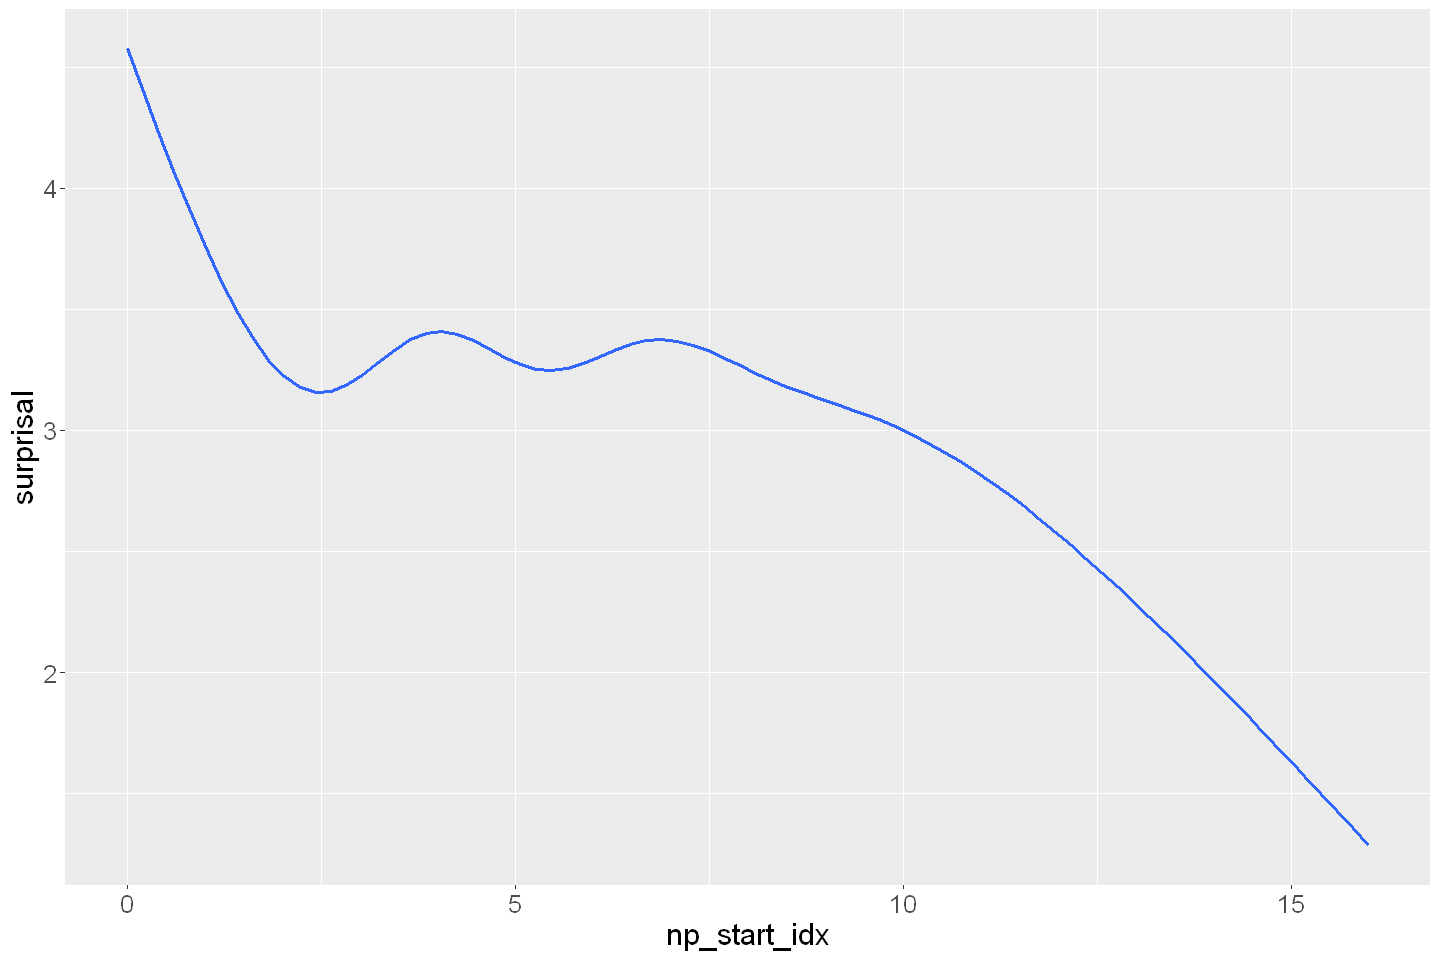

In [35]:
summary(lm(data=df_nps, surprisal ~ np_start_idx))

ggplot(df_nps, aes(x = np_start_idx, y = surprisal)) + 
    geom_smooth(se = FALSE) + 
    plotFont(1.5)

- The effect holds for just NPs; other than a wavering between 4 and 7, it decreases over the course of the sentence. 
- The waver might be because no NP begins at index 1; because sentences were filtered to have subjects begin at index 0, the only possibly word in index 1 is either a non-initial token in an NP or a verb. It may have been smoother if there were NPs at position 1 :

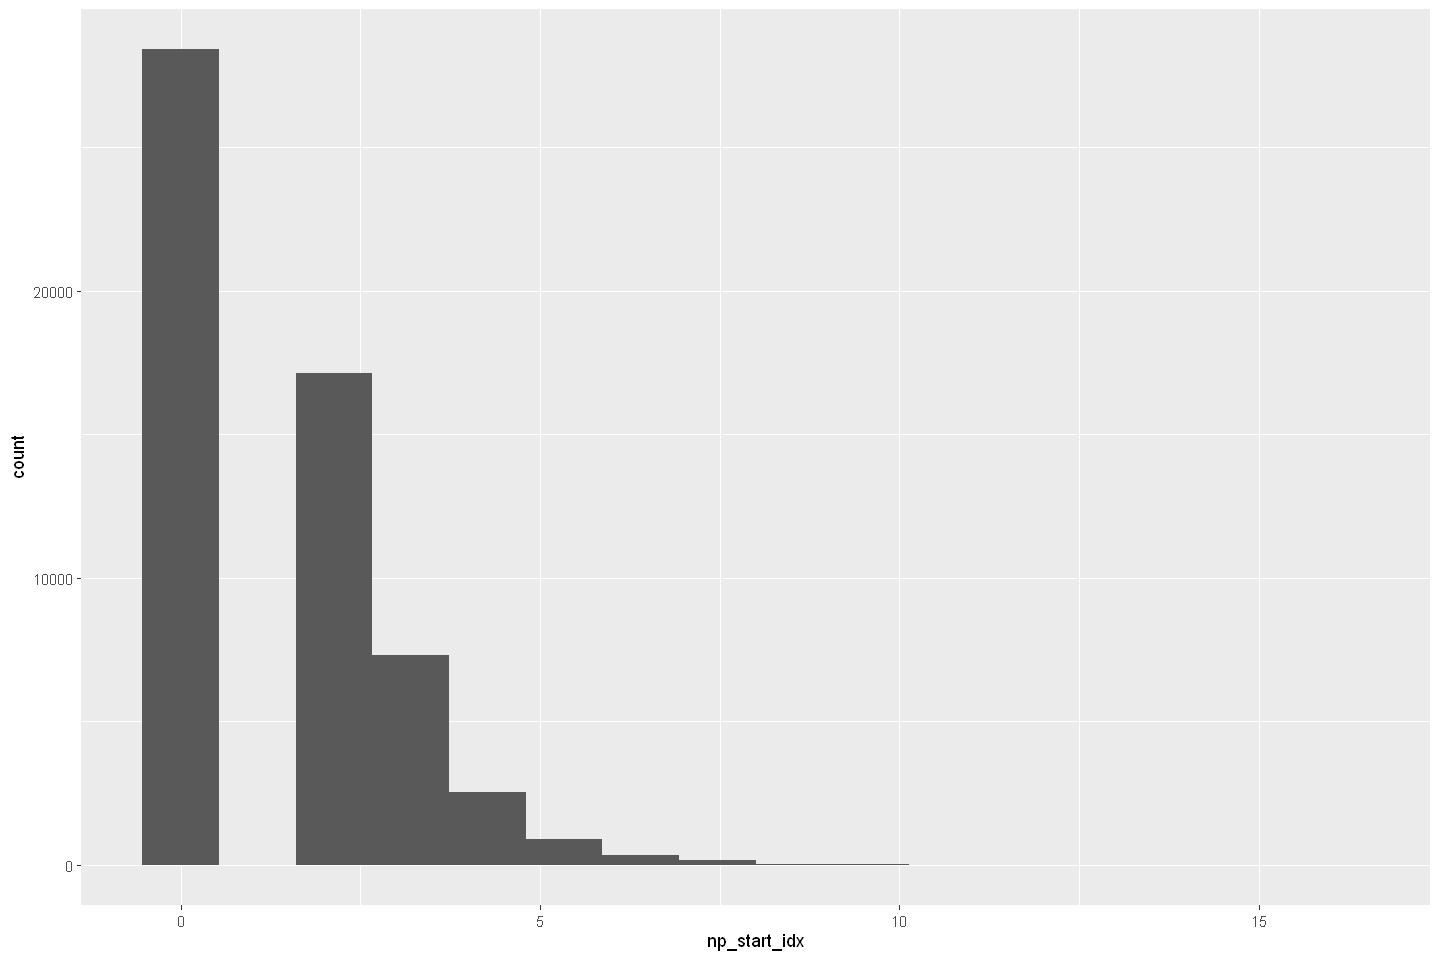

In [36]:
ggplot(data=df_nps, aes(x=np_start_idx)) +
geom_histogram(bins=16)

##### Is it truly a confound

In [37]:
mod_no_idx <- lm(data = df_nps, surprisal ~ argPos * definiteness)
    summary(mod_no_idx)

mod_with_idx <- lm(data=df_nps, surprisal ~ argPos * definiteness * np_start_idx)
    summary(mod_with_idx)



Call:
lm(formula = surprisal ~ argPos * definiteness, data = df_nps)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.9706 -1.8992 -0.5233  1.3200 15.3363 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)                4.00425    0.02498  160.33   <2e-16 ***
argPossbj                  2.21407    0.04997   44.30   <2e-16 ***
definitenessdef           -1.15352    0.03076  -37.50   <2e-16 ***
argPossbj:definitenessdef -0.69799    0.05532  -12.62   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.457 on 56798 degrees of freedom
Multiple R-squared:  0.1126,	Adjusted R-squared:  0.1125 
F-statistic:  2402 on 3 and 56798 DF,  p-value: < 2.2e-16



Call:
lm(formula = surprisal ~ argPos * definiteness * np_start_idx, 
    data = df_nps)

Residuals:
   Min     1Q Median     3Q    Max 
-5.971 -1.900 -0.524  1.319 15.336 

Coefficients: (2 not defined because of singularities)
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                             4.23383    0.06921  61.174  < 2e-16 ***
argPossbj                               1.98449    0.08163  24.311  < 2e-16 ***
definitenessdef                        -1.41442    0.08747 -16.170  < 2e-16 ***
np_start_idx                           -0.08280    0.02328  -3.557 0.000376 ***
argPossbj:definitenessdef              -0.43709    0.09881  -4.423 9.73e-06 ***
argPossbj:np_start_idx                       NA         NA      NA       NA    
definitenessdef:np_start_idx            0.09512    0.03058   3.111 0.001868 ** 
argPossbj:definitenessdef:np_start_idx       NA         NA      NA       NA    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.

Both have significant effects; are the models significantly different? 

In [38]:
anova(mod_no_idx, mod_with_idx)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,56798,342980.1,NA,NA,NA,NA
2,56796,342901.4,2,78.71148,6.518633,0.001476789


- It's significantly better. Should use the model with the position. 


---


In [3]:
df_nps <-  open_dataset("Outputs 12-12/Parquets 12-12 Run/12-12 NPs Only.parquet") %>% collect()

**Should I be using a log(surprisal) instead?**

In [4]:
mod <- lm(data = df_nps, surprisal ~ argPos * definiteness * np_start_idx)
modLog <- lm(data = df_nps, log(surprisal) ~ argPos * definiteness * np_start_idx)

summary(mod)
summary(modLog)


Call:
lm(formula = surprisal ~ argPos * definiteness * np_start_idx, 
    data = df_nps)

Residuals:
   Min     1Q Median     3Q    Max 
-5.971 -1.900 -0.524  1.319 15.336 

Coefficients: (2 not defined because of singularities)
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                             4.23383    0.06921  61.174  < 2e-16 ***
argPossbj                               1.98449    0.08163  24.311  < 2e-16 ***
definitenessdef                        -1.41442    0.08747 -16.170  < 2e-16 ***
np_start_idx                           -0.08280    0.02328  -3.557 0.000376 ***
argPossbj:definitenessdef              -0.43709    0.09881  -4.423 9.73e-06 ***
argPossbj:np_start_idx                       NA         NA      NA       NA    
definitenessdef:np_start_idx            0.09512    0.03058   3.111 0.001868 ** 
argPossbj:definitenessdef:np_start_idx       NA         NA      NA       NA    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.


Call:
lm(formula = log(surprisal) ~ argPos * definiteness * np_start_idx, 
    data = df_nps)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.4228 -0.4404  0.0951  0.5676  2.2560 

Coefficients: (2 not defined because of singularities)
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                             1.276824   0.023550  54.218  < 2e-16
argPossbj                               0.462276   0.027776  16.643  < 2e-16
definitenessdef                        -0.742174   0.029764 -24.936  < 2e-16
np_start_idx                           -0.030362   0.007921  -3.833 0.000127
argPossbj:definitenessdef               0.291435   0.033623   8.668  < 2e-16
argPossbj:np_start_idx                        NA         NA      NA       NA
definitenessdef:np_start_idx            0.063001   0.010405   6.055 1.42e-09
argPossbj:definitenessdef:np_start_idx        NA         NA      NA       NA
                                          
(Intercept)        

Ignoring unknown labels:
• size : ""
Ignoring unknown labels:
• size : ""


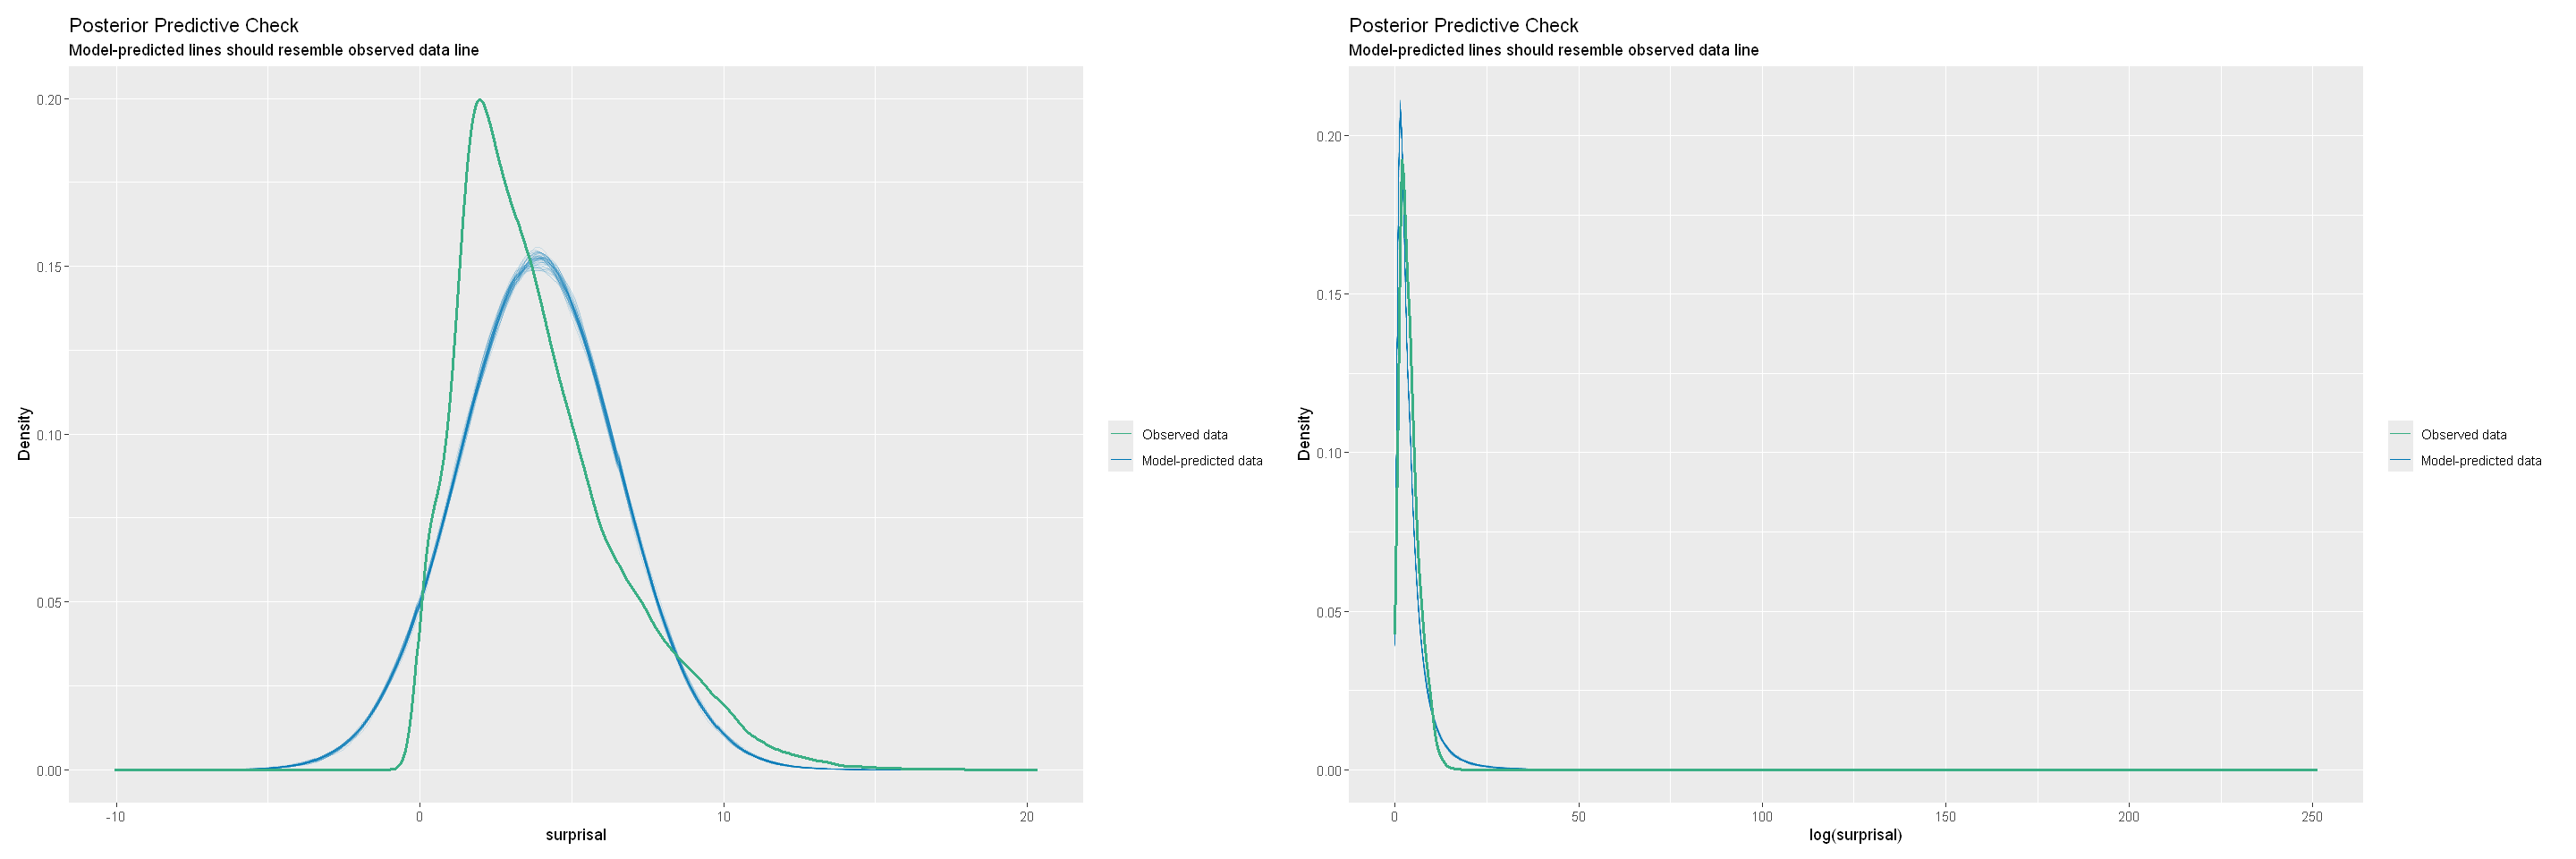

In [10]:
checkMod <- check_predictions(mod)
checkModLog <- check_predictions(modLog)

options(repr.plot.width = 24, repr.plot.height = 8)

plots(plot(checkMod), plot(checkModLog))